<a href="https://colab.research.google.com/github/nikhilbansal23/RottenTomatoesMoviesRatingPrediction/blob/main/rotten_tomatoes_movies_rating_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import uuid
from datetime import datetime
from scipy.stats import norm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
movies = pd.read_csv('/content/drive/MyDrive/Datasets/Rotten Tomatoes/rotten_tomatoes_movies.csv')
critic_reviews = pd.read_csv('/content/drive/MyDrive/Datasets/Rotten Tomatoes/rotten_tomatoes_critic_reviews_50k.csv')

# Feature Engineering - Visualization, Manipulation

In [67]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [68]:
print("Movies data count "+str(len(movies)))
print("Reviews data count "+str(len(critic_reviews)))

Movies data count 17712
Reviews data count 50000


In [69]:
rt = pd.merge(movies, critic_reviews, on='rotten_tomatoes_link', suffixes=('_df1', '_df2'))


In [70]:
date_columns = [col for col in rt.columns if col.endswith('_date')]

# Convert selected columns to datetime
rt[date_columns] = rt[date_columns].apply(pd.to_datetime)

In [71]:
rt.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'critic_name', 'top_critic', 'publisher_name', 'review_type',
       'review_score', 'review_date', 'review_content'],
      dtype='object')

In [72]:
print("Rotten Tomatoes data count "+str(len(rt)))

Rotten Tomatoes data count 50000


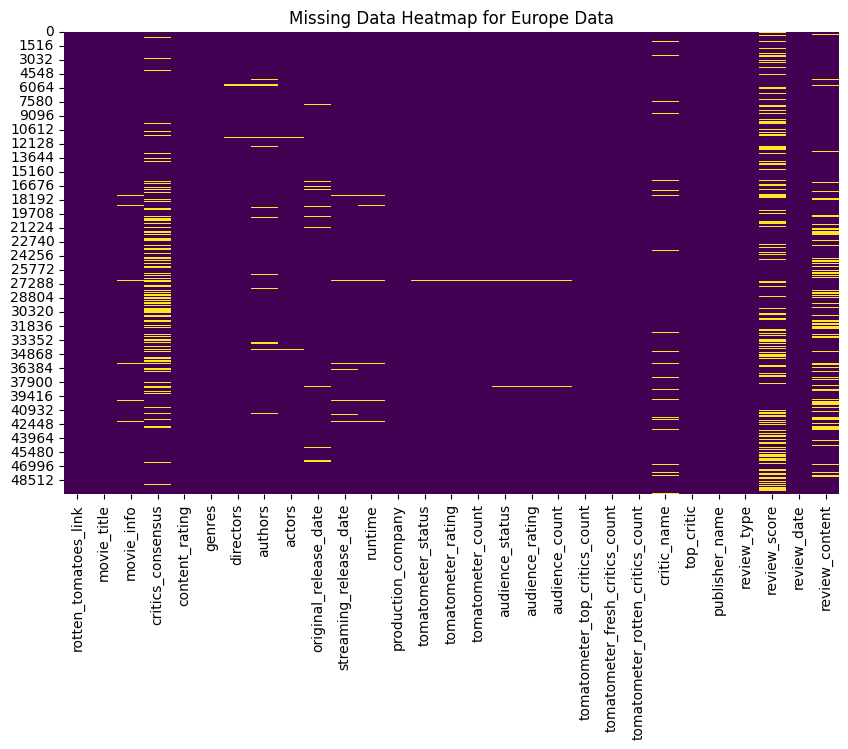

In [73]:
missing_data = rt.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(rt.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [74]:
#cool method to handle null values
def handle_nulls_by_dtype(dataframe, inplace=True):
    for col in dataframe.columns:
        dtype = dataframe[col].dtype
        if pd.api.types.is_numeric_dtype(dtype):
            # Fill null values in numeric columns (including int and float) with 0
            dataframe[col] = dataframe[col].fillna(0)
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            # Fill null values in datetime columns with a specific date (e.g., '2023-01-01')
            dataframe[col] = dataframe[col].fillna(pd.to_datetime('2023-01-01'))
        elif pd.api.types.is_string_dtype(dtype):
            # Fill null values in string columns with a specific value (e.g., 'Unknown')
            dataframe[col] = dataframe[col].fillna('Unknown')
        # Handling integer columns separately
        elif pd.api.types.is_integer_dtype(dtype):
            # Fill null values in integer columns with 0
            dataframe[col] = dataframe[col].fillna(0)

In [75]:
handle_nulls_by_dtype(rt)

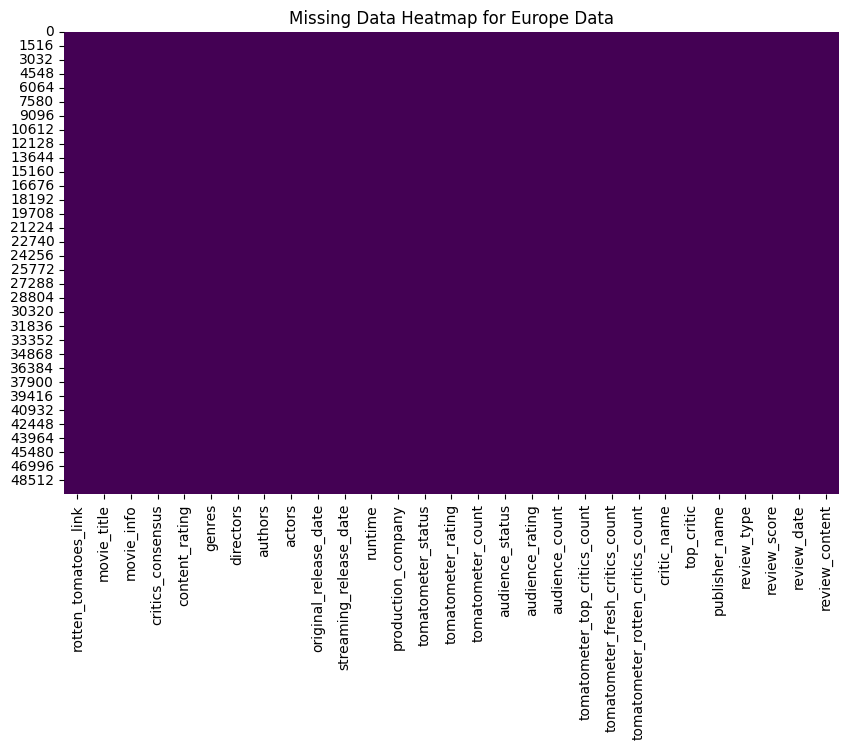

In [76]:
missing_data = rt.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(rt.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap for Europe Data')
plt.show()

In [77]:
rt.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000
mean,107.882440,61.535540,74.987760,63.584400,2.675137e+05,19.372520,44.600680,30.431100
std,23.239817,28.156468,58.884649,20.188914,2.192578e+06,15.022669,42.910912,33.953536
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,95.000000,39.000000,31.000000,48.000000,8.297000e+03,7.000000,15.000000,5.000000
50%,104.000000,67.000000,56.000000,66.000000,3.354900e+04,15.000000,33.000000,16.000000
75%,118.000000,88.000000,112.000000,80.000000,1.004900e+05,31.000000,57.000000,48.000000
max,254.000000,100.000000,309.000000,100.000000,3.340399e+07,58.000000,278.000000,151.000000


In [78]:
rt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rotten_tomatoes_link              50000 non-null  object        
 1   movie_title                       50000 non-null  object        
 2   movie_info                        50000 non-null  object        
 3   critics_consensus                 50000 non-null  object        
 4   content_rating                    50000 non-null  object        
 5   genres                            50000 non-null  object        
 6   directors                         50000 non-null  object        
 7   authors                           50000 non-null  object        
 8   actors                            50000 non-null  object        
 9   original_release_date             50000 non-null  datetime64[ns]
 10  streaming_release_date            50000 non-nu

In [79]:
# Group by 'host_id' and calculate total earnings for each host
review_type = rt.groupby('review_type')['rotten_tomatoes_link'].count().reset_index()
review_type = review_type.rename(columns={'rotten_tomatoes_link': 'count'})

sorted_earnings = review_type.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='review_type', y='count', title='Review Type',
             labels={'review_type': 'Reviews', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [80]:
rt['original_release_year'] = rt['original_release_date'].dt.year

In [81]:
# rt.groupby('review_score')['rotten_tomatoes_link'].count()
rt.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'critic_name', 'top_critic', 'publisher_name', 'review_type',
       'review_score', 'review_date', 'review_content',
       'original_release_year'],
      dtype='object')

In [82]:
# rt.head()

In [83]:
# Group by critic and count the number of reviews
df = rt[rt['critic_name'] != 'Unknown']

reviews_by_critic = df.groupby('critic_name').size().reset_index(name='num_reviews')

# Sort critics by the number of reviews and take the top 10
top_10_critics = reviews_by_critic.nlargest(10, 'num_reviews')

# Merge with the original dataframe to get the top_critic information in the hover
top_10_critics = pd.merge(top_10_critics, df.drop_duplicates('critic_name'), on='critic_name', how='left')

# Plotting with Plotly
fig = px.bar(top_10_critics, x='critic_name', y='num_reviews',
             color='top_critic', color_discrete_map={True: 'blue', False: 'orange'},
             hover_data={'top_critic': True},
             labels={'critic_name': 'Critic Name', 'num_reviews': 'Number of Reviews'},
             title='Top 10 Critics by Number of Reviews')

fig.update_layout(xaxis={'categoryorder': 'total descending'})

fig.show()

In [84]:
df = rt[rt['tomatometer_status'] != 'Unknown']
# Grouping by 'tomatometer_status' and summing the number of reviews
reviews_by_status = df.groupby('tomatometer_status')['rotten_tomatoes_link'].size().reset_index(name='num_reviews')

# Plotting a bar chart with Plotly
fig = px.bar(reviews_by_status, x='tomatometer_status', y='num_reviews',
             labels={'tomatometer_status': 'Tomatometer Status', 'num_reviews': 'Number of Reviews'},
             title='Number of Reviews by Tomatometer Status')

fig.show()

In [85]:

df = rt[rt['audience_status'] != 'Unknown']
# Grouping by 'tomatometer_status' and summing the number of reviews
reviews_by_status = df.groupby('audience_status')['rotten_tomatoes_link'].size().reset_index(name='num_reviews')

# Plotting a bar chart with Plotly
fig = px.bar(reviews_by_status, x='audience_status', y='num_reviews',
             labels={'audience_status': 'Audience Status', 'num_reviews': 'Number of Reviews'},
             title='Number of Reviews by Audience Status')

fig.show()

In [86]:
date_col = ['original_release_year','review_date','streaming_release_date','original_release_date']
rt.drop(date_col, axis=1, inplace = True)

In [87]:
# genres_dummies = rt['genres'].str.get_dummies(sep=', ')
# # Concatenating the one-hot encoded genres with the original DataFrame
# # df = pd.concat([df, genres_dummies], axis=1)
# genres_dummies
# # # Dropping the original 'genre' column
# # df.drop('genre', axis=1, inplace=True)


In [88]:
# Group by 'host_id' and calculate total earnings for each host
production_company = rt.groupby('production_company')['rotten_tomatoes_link'].count().reset_index()
production_company = production_company.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_companies = production_company.head(5)

sorted_earnings = top_10_companies.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='production_company', y='count', title='Production House',
             labels={'production_company': 'Production House', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


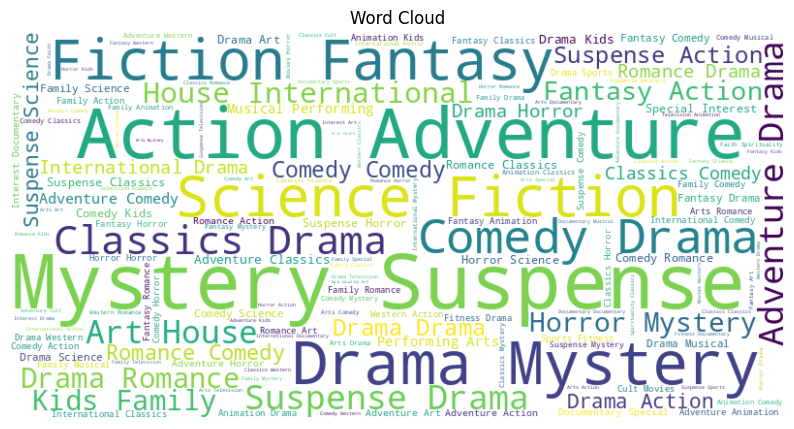

In [89]:
# Concatenate the values from the column into a single string
text = ' '.join(rt['genres'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [90]:
# Splitting the genres and creating a list of all genres
all_genres = [genre.split(', ') for genre in rt['genres']]
all_genres = [item for sublist in all_genres for item in sublist]

# Counting the occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Extracting the most common genres (let's say top 2)
top_genres = genre_counts.head(10).index.tolist()
# Creating new columns for the top genres with binary indicators (0 and 1)
for genre in top_genres:
    rt[genre] = rt['genres'].str.contains(genre).astype(int)

# Dropping the original 'genre' column
rt.drop('genres', axis=1, inplace=True)



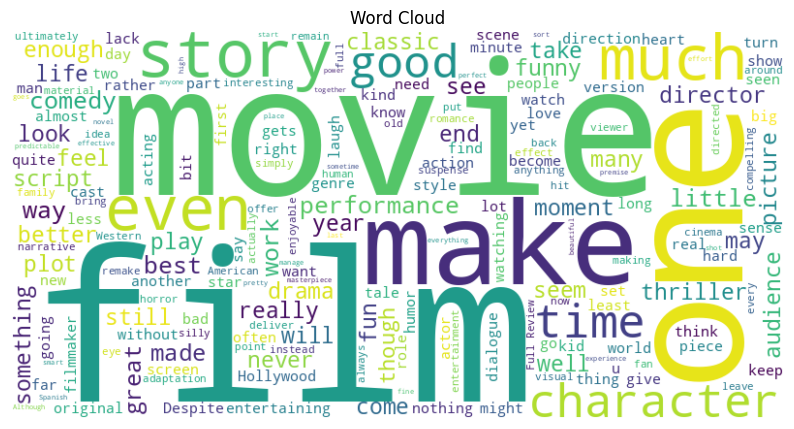

In [91]:
# Concatenate the values from the column into a single string
df = rt[rt['review_content'] != 'Unknown']
text = ' '.join(df['review_content'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


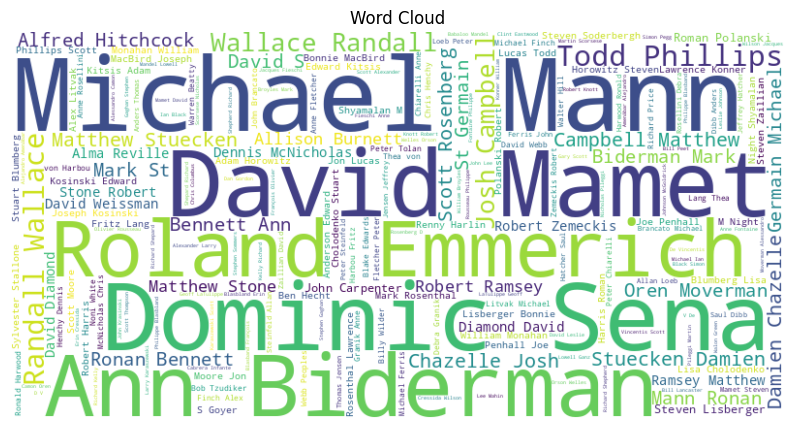

In [92]:
# Concatenate the values from the column into a single string
df = rt[rt['authors'] != 'Unknown']
text = ' '.join(df['authors'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [93]:
# Splitting the authors and creating a list of all author names
all_authors = [author.split(', ') for author in rt['authors']]
all_authors = [item for sublist in all_authors for item in sublist]

# Counting the occurrences of each author
author_counts = pd.Series(all_authors).value_counts()

# Extracting the most common authors (let's say top 2)
top_authors = author_counts.head(10).index.tolist()
# Creating new columns for the top authors with binary indicators (0 and 1)
for author in top_authors:
    rt[author] = rt['authors'].str.contains(author).astype(int)

# Dropping the original 'authors' column
rt.drop('authors', axis=1, inplace=True)

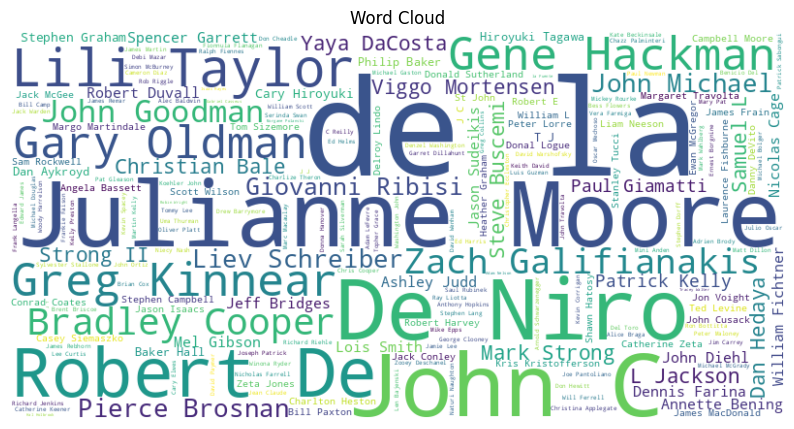

In [94]:
# Concatenate the values from the column into a single string
df = rt[rt['actors'] != 'Unknown']
text = ' '.join(df['actors'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [95]:
# Splitting the actors and creating a list of all actor names
all_actors = [actor.split(', ') for actor in rt['actors']]
all_actors = [item for sublist in all_actors for item in sublist]

# Counting the occurrences of each actor
actor_counts = pd.Series(all_actors).value_counts()

# Extracting the most common actors (let's say top 2)
top_actors = actor_counts.head(10).index.tolist()

# Creating new columns for the top actors with binary indicators (0 and 1)
for actor in top_actors:
    rt[actor] = rt['actors'].str.contains(actor).astype(int)

# Dropping the original 'actors' column
rt.drop('actors', axis=1, inplace=True)

In [96]:
# Function to get sentiment polarity using TextBlob
def get_sentiment(text):
    analysis = TextBlob(text)
    polarity = analysis.sentiment.polarity
    return 1 if polarity > 0 else 0

# Applying sentiment analysis to the 'review_content' column
rt['review_sentiment'] = rt['review_content'].apply(get_sentiment)
rt.drop('review_content', axis=1, inplace=True)

In [97]:
# Group by 'host_id' and calculate total earnings for each host
tomatometer_rating = rt.groupby('tomatometer_rating')['rotten_tomatoes_link'].count().reset_index()
tomatometer_rating = tomatometer_rating.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_companies = tomatometer_rating.head(5)

sorted_earnings = top_10_companies.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='tomatometer_rating', y='count', title='Tomatometer rating',
             labels={'tomatometer_rating': 'Tomatometer Rating', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [98]:
# Group by 'host_id' and calculate total earnings for each host
directors = rt.groupby('directors')['rotten_tomatoes_link'].count().reset_index()
directors = directors.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_directors = directors.head(10)

sorted_earnings = top_10_directors.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='directors', y='count', title='Top 10 Directors',
             labels={'directors': 'Directors', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [99]:
director_counts = rt['directors'].value_counts()

# Extracting the top 10 most common directors
top_10_directors = director_counts.head(10).index.tolist()

# Creating new columns for the top 10 directors with binary indicators (0 and 1) and adding a prefix
for director in top_10_directors:
    rt['director_' + director] = rt['directors'].apply(lambda x: 1 if x == director else 0)

# Dropping the original 'directors' column
rt.drop('directors', axis=1, inplace=True)


In [100]:
production_company_counts = rt['production_company'].value_counts()

# Extracting the top 10 most common directors
top_10_production_company_counts = production_company_counts.head(10).index.tolist()

# Creating new columns for the top 10 directors with binary indicators (0 and 1) and adding a prefix
for pc in top_10_production_company_counts:
    rt['ProductionHouse_' + director] = rt['production_company'].apply(lambda x: 1 if x == pc else 0)

# Dropping the original 'directors' column
rt.drop('production_company', axis=1, inplace=True)


In [101]:
rt.drop(['ProductionHouse_Unknown','director_Unknown','review_score'], axis=1, inplace=True)

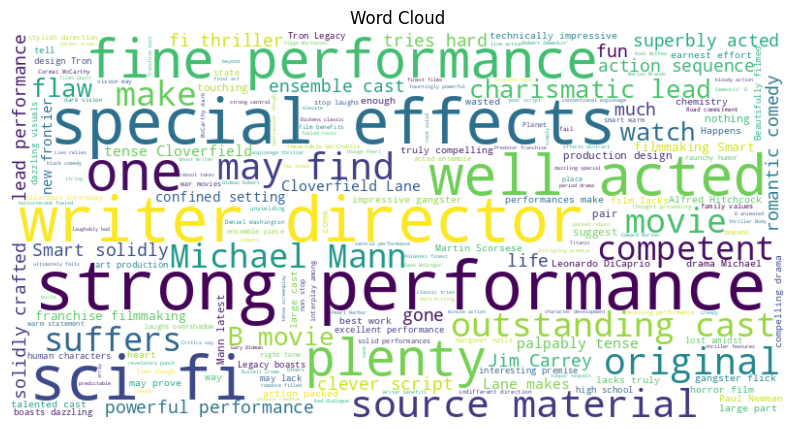

In [102]:
# Concatenate the values from the column into a single string
df = rt[rt['critics_consensus'] != 'Unknown']
text = ' '.join(df['critics_consensus'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))


In [103]:
# Applying sentiment analysis to the 'review_content' column
rt['critics_consensus_sentiment'] = rt['critics_consensus'].apply(get_sentiment)
rt.drop('critics_consensus', axis=1, inplace=True)

In [104]:
# Group by 'host_id' and calculate total earnings for each host
publisher_name = rt.groupby('publisher_name')['rotten_tomatoes_link'].count().reset_index()
publisher_name = publisher_name.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_publisher_name = publisher_name.head(10)

sorted_earnings = top_10_publisher_name.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='publisher_name', y='count', title='Top 10 Publishers',
             labels={'publisher_name': 'Publishers', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [105]:
# Counting the occurrences of each publisher
publisher_counts = rt['publisher_name'].value_counts()

# Extracting the top 10 most common publishers
top_10_publishers = publisher_counts.head(3).index.tolist()

# Creating new columns for the top publishers and filling with binary indicators
for publisher in top_10_publishers:
    rt[f'publisher_{publisher}'] = (rt['publisher_name'] == publisher).astype(int)
rt.drop('publisher_name', axis=1, inplace=True)


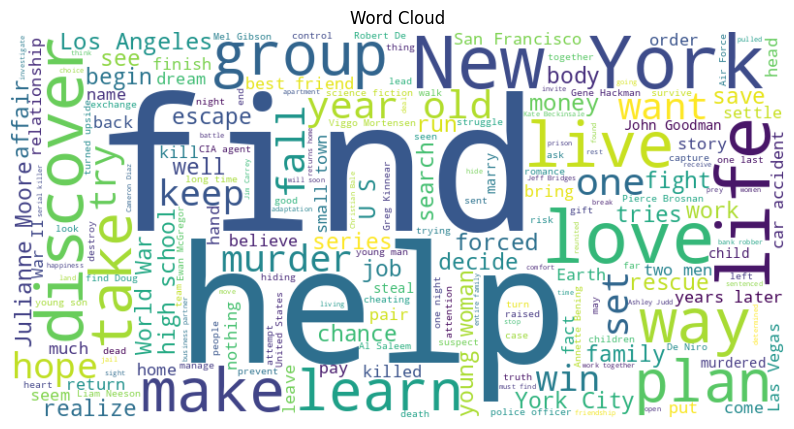

In [106]:
# Concatenate the values from the column into a single string
df = rt[rt['movie_info'] != 'Unknown']
text = ' '.join(df['movie_info'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using Matplotlib (for visualization purposes)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Convert word cloud to Plotly-compatible format and display using Plotly
wordcloud_plotly = go.Figure(go.Image(z=wordcloud.to_array()))
rt.drop('movie_info', axis=1, inplace=True)

In [107]:
# Group by 'host_id' and calculate total earnings for each host
tomatometer_rating = rt.groupby('tomatometer_rating')['rotten_tomatoes_link'].count().reset_index()
tomatometer_rating = tomatometer_rating.rename(columns={'rotten_tomatoes_link': 'count'})
top_10_tomatometer_rating = tomatometer_rating.head(5)

sorted_earnings = top_10_tomatometer_rating.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted_earnings, x='tomatometer_rating', y='count', title='Top 5 Tomatometer Rating',
             labels={'tomatometer_rating': 'Top Tomatometer Rating', 'Count': 'Movies Count'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [108]:
# Define the bins and labels for audience count categories
bins = [0, 1000, 10000, 100000, float('inf')]  # Define your own bin boundaries
labels = ['Low', 'Medium', 'High', 'Very High']

# Create a new column 'Audience Volume' with categorical labels based on audience count bins
rt['Audience_Volume'] = pd.cut(df['audience_count'], bins=bins, labels=labels)


In [109]:
# Define the bins and labels for audience ratings categories
rating_bins = [0, 25, 50, 75, 100]  # Define your own bin boundaries (0-25, 26-50, 51-75, 76-100)
rating_labels = ['Low', 'Moderate', 'Good', 'Excellent']  # Assign text labels to the categories

# Create a new column 'Audience_Rating_Category' with categorical labels based on rating bins
rt['Audience_Rating_Category'] = pd.cut(df['audience_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)
rt.drop('audience_rating', axis=1, inplace=True)

In [110]:
# Categorize runtime into bins, setting >200 as 'Long'
rt['runtime_category'] = pd.cut(rt['runtime'], bins=[0, 90, 120, 200, float('inf')], labels=['Short', 'Medium', 'Long', 'Very Long'])


In [111]:
del_list = ['critic_name','movie_title','rotten_tomatoes_link','audience_count','tomatometer_count','tomatometer_top_critics_count','tomatometer_fresh_critics_count','tomatometer_rotten_critics_count','runtime']
rt.drop(del_list, axis=1, inplace=True)

In [112]:
# Define the bins and labels for audience ratings categories
rating_bins = [0, 25, 50, 75, 100]  # Define your own bin boundaries (0-25, 26-50, 51-75, 76-100)
rating_labels = ['Low', 'Moderate', 'Good', 'Excellent']  # Assign text labels to the categories

# Create a new column 'Audience_Rating_Category' with categorical labels based on rating bins
rt['Tomatometer_Rating_Category'] = pd.cut(df['tomatometer_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)
rt.drop('tomatometer_rating', axis=1, inplace=True)


In [113]:
getdummies = ['audience_status' , 'top_critic', 'review_type' , 'content_rating','Audience_Rating_Category', 'Audience_Volume', 'Tomatometer_Rating_Category','runtime_category']
dummies = pd.get_dummies(rt[getdummies])
dummies = dummies.astype(int)


In [114]:
rt = pd.concat([rt, dummies], axis=1)
rt.drop(columns= getdummies, inplace=True)

In [115]:
rt['tomatometer_status'].value_counts()

Rotten             21474
Fresh              14695
Certified-Fresh    13788
Unknown               43
Name: tomatometer_status, dtype: int64

In [116]:
status_mapping = {
    'Certified-Fresh': 2,
    'Fresh': 1,
    'Rotten': 0
}

# Filter out rows with 'Unknown' values in 'tomatometer_status' column
mask = rt['tomatometer_status'] != 'Unknown'
df_filtered = rt[mask].copy()  # Create a copy to avoid SettingWithCopyWarning

# Map categorical values to integers using .loc[]
df_filtered.loc[mask, 'tomatometer_status'] = df_filtered.loc[mask, 'tomatometer_status'].map(status_mapping)

<ipython-input-116-04bbb15420d9>:12: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [117]:
df_filtered['tomatometer_status'].head()

0    0
1    0
2    0
3    0
4    0
Name: tomatometer_status, dtype: int64

In [118]:
def highly_correlated_columns(df, threshold=0.7):

    # Calculate correlation matrix
    corr_matrix = df.corr().abs()

    # Extract upper triangle of correlation matrix without diagonal
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find column pairs with correlation above the threshold
    highly_correlated = [(col1, col2) for col1 in upper_triangle.columns
                         for col2 in upper_triangle.columns
                         if upper_triangle[col1][col2] > threshold]

    return highly_correlated



In [128]:
correlated_columns = highly_correlated_columns(df_filtered, threshold=0.7)
print("Highly correlated columns:")
print(correlated_columns)

Highly correlated columns:
[('Matthew Stuecken', 'Josh Campbell'), ('director_Michael Mann', 'Michael Mann'), ('director_Dominic Sena', 'Dominic Sena'), ('director_Roland Emmerich', 'Roland Emmerich'), ('director_Todd Phillips', 'Todd Phillips'), ('director_Dan Trachtenberg', 'Josh Campbell'), ('director_Dan Trachtenberg', 'Matthew Stuecken'), ('audience_status_Upright', 'audience_status_Spilled'), ('review_type_Rotten', 'review_type_Fresh'), ('Audience_Rating_Category_Moderate', 'audience_status_Spilled'), ('Audience_Rating_Category_Moderate', 'audience_status_Upright'), ('Tomatometer_Rating_Category_Excellent', 'tomatometer_status')]


In [120]:
# len(df_filtered.columns)

In [129]:
high_corr_cols = [

                  'Josh Campbell','Michael Mann','Dominic Sena','Roland Emmerich','Todd Phillips','Josh Campbell','Matthew Stuecken','audience_status_Spilled','audience_status_Upright','review_type_Fresh'
]

In [130]:
df_filtered.drop(df_filtered[high_corr_cols], axis=1, inplace = True)

# **Model Building**

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [131]:
X = df_filtered.drop('tomatometer_status', axis=1)  # Features
y = df_filtered['tomatometer_status']  # Target variable

## Feature Reduction using OLS

In [132]:
import statsmodels.api as sm
import pandas as pd

# Assuming 'X' contains your features and 'y' contains the target variable

# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X).fit()

# Get p-values for each feature
p_values = model.pvalues

# Select features based on a threshold (e.g., 0.05)
selected_features = p_values[p_values < 0.05].index.tolist()

# Display selected features
print("Selected Features based on p-value:")
print(selected_features)

Selected Features based on p-value:
['const', 'Drama', 'Comedy', 'Mystery & Suspense', 'Action & Adventure', 'Classics', 'Romance', 'Art House & International', 'David Mamet', 'Ann Biderman', 'Randall Wallace', 'Robert De Niro', 'Lili Taylor', 'Greg Kinnear', 'Gary Oldman', 'Zach Galifianakis', 'Bradley Cooper', 'Pierce Brosnan', 'review_sentiment', 'director_Alfred Hitchcock', 'director_Ridley Scott', 'director_Dominic Sena', 'director_Roland Emmerich', 'director_Martin Scorsese', 'director_Todd Phillips', 'director_Michael Bay', 'director_Dan Trachtenberg', 'critics_consensus_sentiment', 'publisher_EmanuelLevy.Com', 'review_type_Rotten', 'content_rating_G', 'content_rating_NC17', 'content_rating_PG', 'content_rating_PG-13', 'content_rating_R', 'Audience_Rating_Category_Low', 'Audience_Rating_Category_Moderate', 'Audience_Rating_Category_Excellent', 'Audience_Volume_Low', 'Audience_Volume_Medium', 'Tomatometer_Rating_Category_Low', 'Tomatometer_Rating_Category_Moderate', 'Tomatometer_

In [133]:
features_to_keep = p_values[p_values < 0.05]
X_reduced = X[features_to_keep.index]
X_reduced = X_reduced.drop('const', axis=1)

In [134]:
X_reduced.columns

Index(['Drama', 'Comedy', 'Mystery & Suspense', 'Action & Adventure',
       'Classics', 'Romance', 'Art House & International', 'David Mamet',
       'Ann Biderman', 'Randall Wallace', 'Robert De Niro', 'Lili Taylor',
       'Greg Kinnear', 'Gary Oldman', 'Zach Galifianakis', 'Bradley Cooper',
       'Pierce Brosnan', 'review_sentiment', 'director_Alfred Hitchcock',
       'director_Ridley Scott', 'director_Dominic Sena',
       'director_Roland Emmerich', 'director_Martin Scorsese',
       'director_Todd Phillips', 'director_Michael Bay',
       'director_Dan Trachtenberg', 'critics_consensus_sentiment',
       'publisher_EmanuelLevy.Com', 'review_type_Rotten', 'content_rating_G',
       'content_rating_NC17', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'Audience_Rating_Category_Low',
       'Audience_Rating_Category_Moderate',
       'Audience_Rating_Category_Excellent', 'Audience_Volume_Low',
       'Audience_Volume_Medium', 'Tomatometer_Rating_Category_

In [174]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


## **Logistic Regression**

In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Assuming X_train, X_val, X_test, y_train, y_val, y_test are already defined from the previous split

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # You can adjust parameters as needed

# Train the model
logreg.fit(X_train, y_train)


# Predict on validation set
lg_val_predictions = logreg.predict(X_val)


# Predict on test set
lg_test_predictions = logreg.predict(X_test)

# Calculate accuracy on test set
lg_test_accuracy = accuracy_score(y_test, lg_test_predictions)
# Calculate accuracy on validation set
lg_val_accuracy = accuracy_score(y_val, lg_val_predictions)

print("Test Accuracy:", lg_test_accuracy)
print("Validation Accuracy:", lg_val_accuracy)


Test Accuracy: 0.8596877502001601
Validation Accuracy: 0.8688951160928743


In [201]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
lg_test_precision = precision_score(y_test, lg_test_predictions, average='macro')
lg_test_recall = recall_score(y_test, lg_test_predictions, average='macro')
lg_test_f1 = f1_score(y_test, lg_test_predictions, average='macro')

print("Precision:", lg_test_precision)
print("Recall:", lg_test_recall)
print("F1-score:", lg_test_f1)

Precision: 0.8498942786121737
Recall: 0.8528356445009414
F1-score: 0.8509037604152936


In [202]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
lg_val_precision = precision_score(y_val, lg_val_predictions, average='macro')
lg_val_recall = recall_score(y_val, lg_val_predictions, average='macro')
lg_val_f1 = f1_score(y_val, lg_val_predictions, average='macro')

print("Precision:", lg_val_precision)
print("Recall:", lg_val_recall)
print("F1-score:", lg_val_f1)

Precision: 0.8574793842394112
Recall: 0.859989608144529
F1-score: 0.8585180699986402


In [205]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_test, lg_test_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix of Logistic Regression on Test Data',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


In [206]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_val, lg_val_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix of Logistic Regression on Validation Data',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


## Random Forrest

In [209]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(X_train, y_train)

# Predict on test set
rf_test_predictions = random_forest.predict(X_test)

rf_val_predictions = random_forest.predict(X_val)

# Calculate accuracy on validation set
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_val_accuracy = accuracy_score(y_val, rf_val_predictions)

print("Test Accuracy:", rf_test_accuracy)
print("Validation Accuracy:", rf_val_accuracy)


Test Accuracy: 0.9921937550040032
Validation Accuracy: 0.9905924739791834


In [227]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
rf_test_precision = precision_score(y_test, rf_test_predictions, average='macro')
rf_test_recall = recall_score(y_test, rf_test_predictions, average='macro')
rf_test_f1 = f1_score(y_test, rf_test_predictions, average='macro')

print("Precision:", rf_test_precision)
print("Recall:", rf_test_recall)
print("F1-score:", rf_test_f1)

Precision: 0.9909440805018961
Recall: 0.9910023492522032
F1-score: 0.9909468646581105


In [211]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
rf_val_precision = precision_score(y_val, rf_val_predictions, average='macro')
rf_val_recall = recall_score(y_val, rf_val_predictions, average='macro')
rf_val_f1 = f1_score(y_val, rf_val_predictions, average='macro')

print("Precision:", rf_val_precision)
print("Recall:", rf_val_recall)
print("F1-score:", rf_val_f1)

Precision: 0.9889142144322078
Recall: 0.9891628394166466
F1-score: 0.9889957200555822


In [212]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_test, rf_test_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix of Random Forrest on Test Data',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


In [213]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_val, rf_val_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix of Random Forrest on Validation Data',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


## **Decision Tree**

In [224]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_train, y_train)

# Predict on test set
dt_test_predictions = decision_tree.predict(X_test)
dt_val_predictions = decision_tree.predict(X_val)

dt_test_accuracy = accuracy_score(y_test, dt_test_predictions)
dt_val_accuracy = accuracy_score(y_val, dt_val_predictions)

print("Test Accuracy:", dt_test_accuracy)
print("Validation Accuracy:", dt_val_accuracy)


Test Accuracy: 0.9925940752602082
Validation Accuracy: 0.9909927942353883


In [215]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
dt_test_precision = precision_score(y_test, dt_test_predictions, average='macro')
dt_test_recall = recall_score(y_test, dt_test_predictions, average='macro')
dt_test_f1 = f1_score(y_test, dt_test_predictions, average='macro')

print("Precision:", dt_test_precision)
print("Recall:", dt_test_recall)
print("F1-score:", dt_test_f1)

Precision: 0.9912548303816617
Recall: 0.9914709820374435
F1-score: 0.9913335651762555


In [216]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
dt_val_precision = precision_score(y_val, dt_val_predictions, average='macro')
dt_val_recall = recall_score(y_val, dt_val_predictions, average='macro')
dt_val_f1 = f1_score(y_val, dt_val_predictions, average='macro')

print("Precision:", dt_val_precision)
print("Recall:", dt_val_recall)
print("F1-score:", dt_val_f1)

Precision: 0.9893836032821038
Recall: 0.9896462815244541
F1-score: 0.9894643353514262


In [217]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_test, dt_test_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix for Decision Tree on Test Data',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


In [218]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_val, dt_val_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix of Decision Tree on Validation Data',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


## **Support Vector Machines (SVM)**

In [225]:
from sklearn.svm import SVC

# Initialize the model
svm = SVC()

# Train the model
svm.fit(X_train, y_train)

# Predict on test set
svc_test_predictions = svm.predict(X_test)
svc_val_predictions = svm.predict(X_val)


svc_test_accuracy = accuracy_score(y_test, svc_test_predictions)
svc_val_accuracy = accuracy_score(y_val, svc_val_predictions)

print("Test Accuracy:", svc_test_accuracy)
print("Validation Accuracy:", svc_val_accuracy)



Test Accuracy: 0.9791833466773419
Validation Accuracy: 0.9845876701361089


In [226]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
svc_test_precision = precision_score(y_test, svc_test_predictions, average='macro')
svc_test_recall = recall_score(y_test, svc_test_predictions, average='macro')
svc_test_f1 = f1_score(y_test, svc_test_predictions, average='macro')

print("Precision:", svc_test_precision)
print("Recall:", svc_test_recall)
print("F1-score:", svc_test_f1)

Precision: 0.9762146201654937
Recall: 0.9774701551771653
F1-score: 0.9766818872160319


In [221]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for the test set using 'macro' average
svc_val_precision = precision_score(y_val, svc_val_predictions, average='macro')
svc_val_recall = recall_score(y_val, svc_val_predictions, average='macro')
svc_val_f1 = f1_score(y_val, svc_val_predictions, average='macro')

print("Precision:", svc_val_precision)
print("Recall:", svc_val_precision)
print("F1-score:", svc_val_precision)

Precision: 0.9822519255510245
Recall: 0.9822519255510245
F1-score: 0.9822519255510245


In [222]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_test, svc_test_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


In [223]:
import plotly.figure_factory as ff

# Assuming you have conf_matrix from previous calculations
# conf_matrix = confusion_matrix(y_test, test_predictions)

# Define class names if needed
class_names = ['Rotten', 'Fresh', 'Certified-Fresh']  # Replace with your class names
conf_matrix = confusion_matrix(y_val, svc_val_predictions)
# Create a figure
fig = ff.create_annotated_heatmap(
    z=conf_matrix,
    x=class_names,
    y=class_names,
    colorscale='Viridis',
    showscale=True,
    reversescale=True,
)

# Customize the layout
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

# Show the figure
fig.show()


# **Model Comaprisons over Test Data**


In [231]:
import plotly.graph_objs as go
import plotly.express as px

# Assuming you have lists or arrays containing metrics for different models
# Replace these with your actual data

models = ['Logistic Regression', 'Random Forrest', 'Descision Trees','SVM']  # Names of the models
accuracy = [lg_test_accuracy, rf_test_accuracy, dt_test_accuracy, svc_test_accuracy]  # Accuracy values
f1_scores = [lg_test_f1, rf_test_f1, dt_test_f1, svc_test_f1]  # F1-score values
precision = [lg_test_precision, rf_test_precision, dt_test_precision,svc_test_precision]  # Precision values
recall = [lg_test_recall, rf_test_recall, dt_test_recall,svc_test_recall]  # Recall values

# Convert values to percentages
accuracy_percent = [val * 100 for val in accuracy]
f1_scores_percent = [val * 100 for val in f1_scores]
precision_percent = [val * 100 for val in precision]
recall_percent = [val * 100 for val in recall]

melted_data = data.melt(id_vars='Models', var_name='Metrics', value_name='Values')

# Create separate bar charts for each metric using Plotly Express
fig_accuracy = px.bar(melted_data[melted_data['Metrics'] == 'Accuracy'], x='Models', y='Values',
                      title='Comparison of Model Accuracies', labels={'Values': 'Accuracy (%)'})
fig_f1 = px.bar(melted_data[melted_data['Metrics'] == 'F1-score'], x='Models', y='Values',
                title='Comparison of Model F1-scores', labels={'Values': 'F1-score (%)'})
fig_precision = px.bar(melted_data[melted_data['Metrics'] == 'Precision'], x='Models', y='Values',
                       title='Comparison of Model Precisions', labels={'Values': 'Precision (%)'})
fig_recall = px.bar(melted_data[melted_data['Metrics'] == 'Recall'], x='Models', y='Values',
                    title='Comparison of Model Recalls', labels={'Values': 'Recall (%)'})

# Show the charts
fig_accuracy.show()
fig_f1.show()
fig_precision.show()
fig_recall.show()

# **Model Comaprisons over Validation Data**


In [232]:
import plotly.graph_objs as go
import plotly.express as px

# Assuming you have lists or arrays containing metrics for different models
# Replace these with your actual data

models = ['Logistic Regression', 'Random Forrest', 'Descision Trees','SVM']  # Names of the models
accuracy = [lg_val_accuracy, rf_val_accuracy, dt_val_accuracy, svc_val_accuracy]  # Accuracy values
f1_scores = [lg_val_f1, rf_val_f1, dt_val_f1, svc_val_f1]  # F1-score values
precision = [lg_val_precision, rf_val_precision, dt_val_precision,svc_val_precision]  # Precision values
recall = [lg_val_recall, rf_val_recall, dt_val_recall,svc_val_recall]  # Recall values

# Convert values to percentages
accuracy_percent = [val * 100 for val in accuracy]
f1_scores_percent = [val * 100 for val in f1_scores]
precision_percent = [val * 100 for val in precision]
recall_percent = [val * 100 for val in recall]

melted_data = data.melt(id_vars='Models', var_name='Metrics', value_name='Values')

# Create separate bar charts for each metric using Plotly Express
fig_accuracy = px.bar(melted_data[melted_data['Metrics'] == 'Accuracy'], x='Models', y='Values',
                      title='Comparison of Model Accuracies', labels={'Values': 'Accuracy (%)'})
fig_f1 = px.bar(melted_data[melted_data['Metrics'] == 'F1-score'], x='Models', y='Values',
                title='Comparison of Model F1-scores', labels={'Values': 'F1-score (%)'})
fig_precision = px.bar(melted_data[melted_data['Metrics'] == 'Precision'], x='Models', y='Values',
                       title='Comparison of Model Precisions', labels={'Values': 'Precision (%)'})
fig_recall = px.bar(melted_data[melted_data['Metrics'] == 'Recall'], x='Models', y='Values',
                    title='Comparison of Model Recalls', labels={'Values': 'Recall (%)'})

# Show the charts
fig_accuracy.show()
fig_f1.show()
fig_precision.show()
fig_recall.show()